In [ ]:
train_kwargs = {
    "enc_arch": "resnet50",
    "enc_path": None,
    "classifier_type": "one_hot",
    "seed": 0,
    "cudnn_deterministic": False,
    "batch_size": 64,
    "num_workers": 4,
    "validation_ratio": 0.,
    "fine_tune": True,
    "optimizer_name": "adamw",
    "lr": 1e-4,
    "warmup_start_lr": 1e-6,
    "min_lr": 1e-6,
    "weight_decay": 1e-4,
    "scheduler_name": "warmup_cosine",
    "max_epochs": 100,
    "warmup_epochs": 10,
    "save_model": True,
    "save_curves": True,
    "use_benthicnet_normalization": False,
}

In [2]:
from types import SimpleNamespace

import pandas as pd
import torch

from utils.dataset import FathomNetDataset
from utils.utils import build_model, df_split, get_augs, map_label_to_idx, set_seed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_kwargs = SimpleNamespace(**train_kwargs)

# Set seed for reproducibility
set_seed(train_kwargs.seed, cudnn_deterministic=train_kwargs.cudnn_deterministic)

df = pd.read_csv("./data/train/annotations.csv")
test_df = pd.read_csv("./data/test/annotations.csv")

df, label_map = map_label_to_idx(df, "label")

train_df, val_df = df_split(
    df, validation_ratio=train_kwargs.validation_ratio, seed=train_kwargs.seed
)

train_augs, val_augs = get_augs(
    colour_jitter=False, 
    use_benthicnet=train_kwargs.use_benthicnet_normalization
    )

train_dataset = FathomNetDataset(
    df=train_df, 
    label_col="label_idx",
    transform=train_augs,
    )

train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_kwargs.batch_size,
        shuffle=True,
        num_workers=train_kwargs.num_workers,
        pin_memory=True,
        drop_last=True,
    )

if train_kwargs.validation_ratio > 0:
    val_dataset = FathomNetDataset(
        df=val_df, 
        label_col="label_idx",
        transform=val_augs,
        )

    val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=train_kwargs.batch_size,
            shuffle=False,
            num_workers=train_kwargs.num_workers,
            pin_memory=True
        )
else:
    val_dataset = []
    val_dataloader = None

test_dataset = FathomNetDataset(
    df=test_df, 
    label_col="label_idx",
    transform=val_augs,
    is_test=True,
    )

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=train_kwargs.batch_size,
        shuffle=False,
        num_workers=train_kwargs.num_workers,
        pin_memory=True
    )

print("Total samples:", len(df))
print(len(train_dataset), f"training samples, {len(train_dataset)/len(df):.2%} of total")
print(len(val_dataset), f"validation samples, {len(val_dataset)/len(df):.2%} of total")

train_kwargs.steps_per_epoch = len(train_dataloader)

if train_kwargs.classifier_type == "one_hot":
    output_dim = len(label_map)
else:
    raise ValueError("Unsupported classifier type.")

model = build_model(
    encoder_arch=train_kwargs.enc_arch,
    encoder_path=train_kwargs.enc_path,
    classifier_type=train_kwargs.classifier_type,
    requires_grad=train_kwargs.fine_tune,
    output_dim=output_dim,
)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()

Total samples: 23699
23699 training samples, 100.00% of total
0 validation samples, 0.00% of total
No encoder weights loaded.


Epoch [1/100], Loss: 4.3717, Accuracy: 1.39%
Epoch [2/100], Loss: 4.3546, Accuracy: 1.77%
Epoch [3/100], Loss: 4.3386, Accuracy: 2.15%
Epoch [4/100], Loss: 4.3192, Accuracy: 2.91%
Epoch [5/100], Loss: 4.3001, Accuracy: 4.08%
Epoch [6/100], Loss: 4.2788, Accuracy: 5.02%
Epoch [7/100], Loss: 4.2547, Accuracy: 6.56%
Epoch [8/100], Loss: 4.2268, Accuracy: 7.97%
Epoch [9/100], Loss: 4.1955, Accuracy: 9.39%
Epoch [10/100], Loss: 4.1560, Accuracy: 11.41%
Epoch [11/100], Loss: 4.1128, Accuracy: 12.66%
Epoch [12/100], Loss: 4.0665, Accuracy: 14.08%
Epoch [13/100], Loss: 4.0188, Accuracy: 15.35%
Epoch [14/100], Loss: 3.9674, Accuracy: 17.09%
Epoch [15/100], Loss: 3.9110, Accuracy: 18.53%
Epoch [16/100], Loss: 3.8592, Accuracy: 19.62%
Epoch [17/100], Loss: 3.8022, Accuracy: 20.73%
Epoch [18/100], Loss: 3.7363, Accuracy: 21.94%
Epoch [19/100], Loss: 3.6728, Accuracy: 22.86%
Epoch [20/100], Loss: 3.6039, Accuracy: 23.67%
Epoch [21/100], Loss: 3.5355, Accuracy: 24.98%
Epoch [22/100], Loss: 3.4661, A

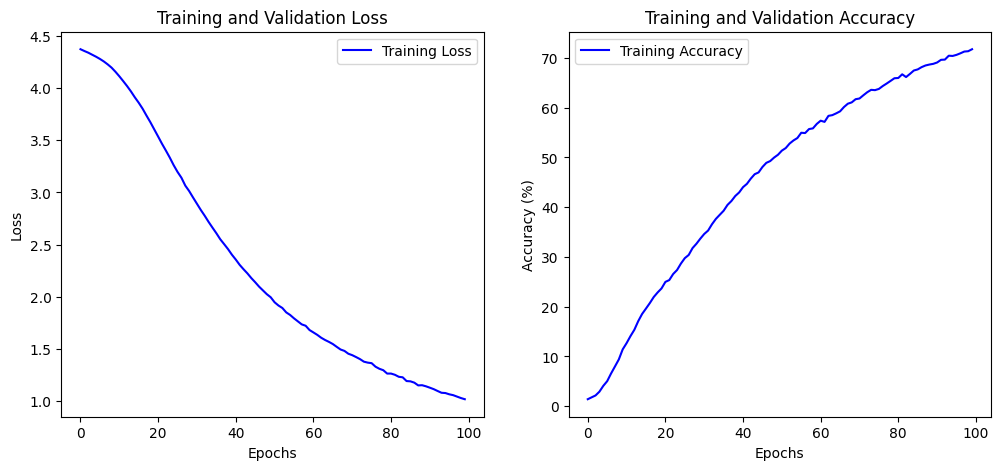

In [3]:
from utils.utils import train

train(
    model=model, 
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    test_loader=test_dataloader,
    label_map=label_map,
    criterion=criterion, 
    device=device,
    train_kwargs=train_kwargs,
    )